In [2]:
import numpy as np
from qcm_data import columns, extract_rotations, interpolate, integrate, read_hdf, read_csv

In [3]:
period = 10

theta = np.unwrap(read_hdf('data/Z-230901A.h5', 'data', columns['theta']))

freq_raw = -1.0 * read_hdf('data/Z-230901A.h5', 'data', 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta, freq_raw, limits=(np.deg2rad(270), np.deg2rad(390)))
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [13]:
from robust_holt_winters import robust_holt_winters, training, initialise, smoothe
import jax.numpy as jnp
from tqdm.auto import tqdm

# series of signal - background
series = freq_int / freq_int.max()

# results of a training
lambda1, lambda2, lambda_sigma = 0.00228908, 0.00228825, 0.09696817

#creating a smoother object
smoother = robust_holt_winters(lambda1=lambda1, lambda2=lambda2, lambda_sigma=lambda_sigma)

# skipping first n_start points and allocating n_warmup points to create an initial state
n_start, n_warmup = int(0.01 * series.size), int(0.04 * series.size)

warmup, samples = (jnp.array(series[n_start:n_start + n_warmup]),
                   jnp.array(series[n_start + n_warmup:]))

# creating an initial state
state = initialise(smoother, warmup)

# performing real-time smoothing
result = []
for elem in tqdm(samples):
    smoothed, state = smoothe(smoother, elem, state)
    result.append(smoothed)

  0%|          | 0/16639 [00:00<?, ?it/s]

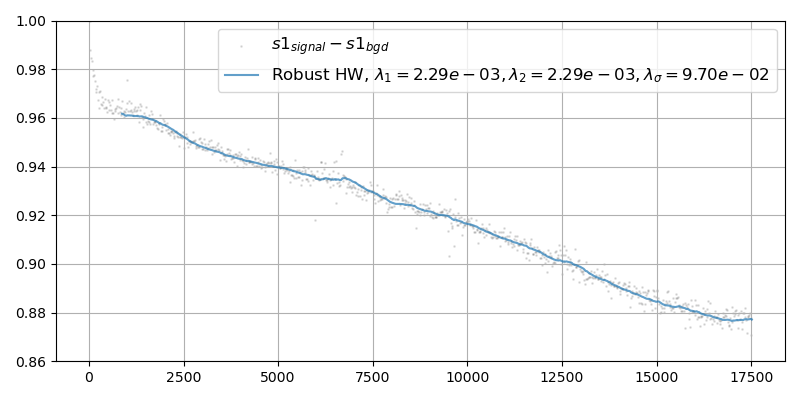

In [14]:
import matplotlib.pyplot as plt

%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(theta_ext[::20], series[::20], s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')
ax.plot(theta_ext[n_start + n_warmup:], result, alpha=0.7,
        label=fr'Robust HW, $\lambda_1 = {lambda1:0.2e}, \lambda_2 = {lambda2:0.2e}, \lambda_{{\sigma}} = {lambda_sigma:0.2e}$')

ax.legend(fontsize=12)
ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()